# Load data

In [23]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import random
from scipy.ndimage.measurements import label
%matplotlib inline  

In [2]:
def load_images(path):
    files = [file for folder in os.walk(path) for file in glob.glob(os.path.join(folder[0], '*.png'))]
    random.shuffle(files)
    return files

cars = load_images("data/vehicles/")
notcars = load_images("data/non-vehicles/")

total  cars :  8792
total  notcars :  8968


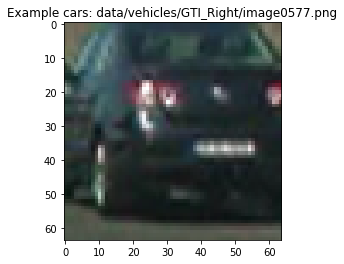

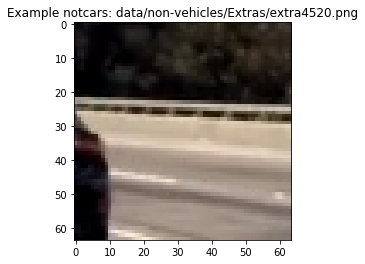

In [3]:
def describe(cars, title):
    print("total ", title, ": ", len(cars))
    car=cars[0]
    car_img = mpimg.imread(car)
    plt.figure()
    plt.title("Example {}: {}".format(title, car))
    plt.imshow(car_img)

describe(cars,"cars")
describe(notcars,"notcars")
    
    

# Extract features

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

/home/chomnoue/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


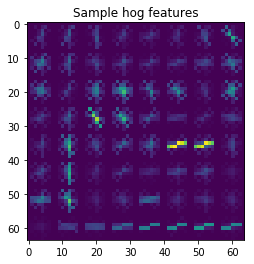

In [10]:
sample_hog_image= get_hog_features(mpimg.imread(cars[0])[:,:,0], 9, 8, 2,vis=True, feature_vec=False)[1]
plt.figure()
plt.title("Sample hog features")
plt.imshow(sample_hog_image)

# Build Model

In [6]:
def build_model(colorspace, orient, pix_per_cell, cell_per_block, hog_channel, cars_sampe, notcars_sample):
    t=time.time()
    car_features = extract_features(cars_sampe, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    notcar_features = extract_features(notcars_sample, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    print('Using: ',colorspace," color space, ",orient,' orientations, ',pix_per_cell,
                            ' pixels per cell, ', cell_per_block,' cells per block and ',hog_channel, ' hog channel')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    accuracy = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', accuracy)
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc, X_scaler, accuracy

## Choice of HOG parameters

In [ ]:
# Reduce the sample size because HOG features are slow to compute
sample_size = 500
cars_sampe = cars[0:sample_size]
notcars_sample = notcars[0:sample_size]
max_accuracy = 0
max_parameters = ()
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
orients = [6,9,12]
pix_per_cells = [4, 8,16]
cell_per_blocks = [2,4]
hog_channels = [0, 1, 2, "ALL"]
total_steps = len(color_spaces)*len(orients)*len(pix_per_cells)*len(cell_per_blocks)*len(hog_channels)
step = 0
for colorspace in color_spaces:
    for orient in  orients:
        for pix_per_cell in pix_per_cells:
            for cell_per_block in cell_per_blocks:
                for hog_channel in hog_channels:    
                    step=step+1
                    parameters = (colorspace, orient, pix_per_cell, cell_per_block, hog_channel)
                    print("")
                    print("**************************************************************")
                    print("running step {}/{} ({}%)".format(step,total_steps, 100.0*step/total_steps))
                    print("parameters: ",parameters)
                    try:
                        svc, X_scaler, accuracy = build_model(colorspace, orient, pix_per_cell, cell_per_block, hog_channel, cars_sampe, notcars_sample)
                    except Exception as err:
                        print(err)
                        continue
                    if(accuracy > max_accuracy):
                        print("got max accuracy!")
                        max_accuracy = accuracy
                        max_parameters = parameters

##  Train with full data

In [7]:
colorspace, orient, pix_per_cell, cell_per_block, hog_channel = 'YCrCb', 9, 4, 2, 'ALL'
svc, X_scaler, accuracy = build_model(colorspace, orient, pix_per_cell, cell_per_block, hog_channel, cars[:5000], notcars[:5000])

/home/chomnoue/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


195.97 Seconds to extract HOG features...
Using:  YCrCb  color space,  9  orientations,  4  pixels per cell,  2  cells per block and  ALL  hog channel
Feature vector length: 24300
5.18 Seconds to train SVC...
Test Accuracy of SVC =  0.979
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
0.00202 Seconds to predict 10 labels with SVC


# Hog Sub-sampling Window Search

In [29]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[]
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Scale features and make a prediction
            test_features = X_scaler.transform(hog_features.reshape(1, -1)) 
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))) 
                
    return bbox_list

# Heat map for single detection per car

In [126]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_labeled_bboxes(img, labels):
    bbox_list=[]
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox)
    # Return the bbox list
    return bbox_list

def apply_heat_map_detection(img, bbox_list, treshold):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bbox_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,treshold)

    # Get the heatmap    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    bbox_list = get_labeled_bboxes(img, labels)
    return bbox_list, heatmap


In [161]:
n=10
# Track the n previous detections
class Tracker():
    def __init__(self):
        self.reset()

    def reset(self):
        self.previous_bbox_list=[]
        
    def add(self, bbox_list):
        self.previous_bbox_list.append(bbox_list)
        if len(self.previous_bbox_list)>n :
            self.previous_bbox_list=self.previous_bbox_list[-n:]
        
    def get_previoust_bbox_list(self):
         return [bbox for sublist in self.previous_bbox_list for bbox in sublist]

tracker = Tracker()

In [52]:
def draw_bboxes(img, bbox_list):    
    draw_img = np.copy(img)
    for bbox in bbox_list:
        cv2.rectangle(draw_img,bbox[0],bbox[1],(0,0,255),6)
    return draw_img

In [53]:
def display_img(img, title, cmap=None):    
    plt.figure()
    plt.title(title)
    plt.imshow(img, cmap=cmap)

# Car detection pipeline

In [162]:
ystart = 375
ystop = 656
scale = 1.5
def pipeline(img, display=False, title="", use_previous=False):
    detected_bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    bbox_list, heatmap = apply_heat_map_detection(img, detected_bbox_list,1)
    if use_previous:
        previous_bbox_list = tracker.get_previoust_bbox_list()
        tracker.add(bbox_list)
        # use heat map to keap only boxes matching detections in previous frames
        if len(previous_bbox_list) >= n :
            bbox_list, heatmap = apply_heat_map_detection(img, previous_bbox_list+bbox_list,8)          
    img_with_final_bboxes = draw_bboxes(img,bbox_list)    
    if display:
        img_with_detcted_bboxes = draw_bboxes(img, detected_bbox_list)
        display_img(img_with_detcted_bboxes, title + " With Hog Sub-sampling Window Search")
        display_img(heatmap, title + " heatmap",  cmap='hot')        
        display_img(img_with_final_bboxes, title+ " with final bboxes")
    return img_with_final_bboxes
        
        

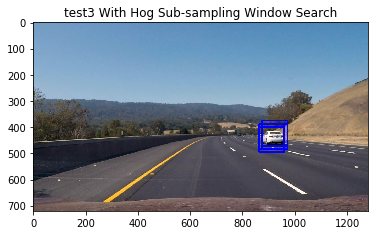

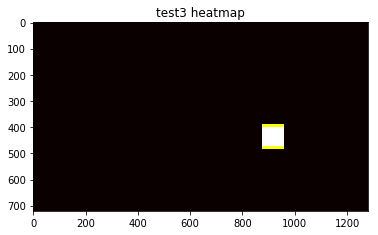

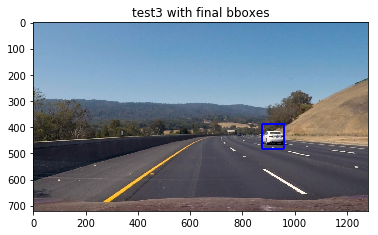

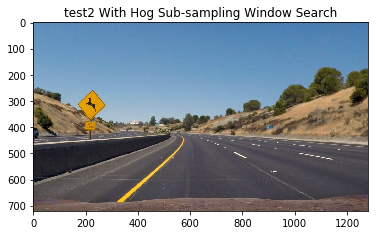

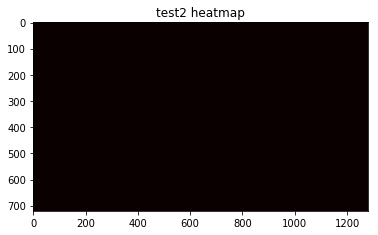

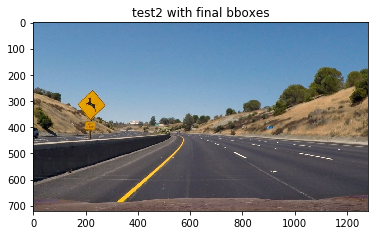

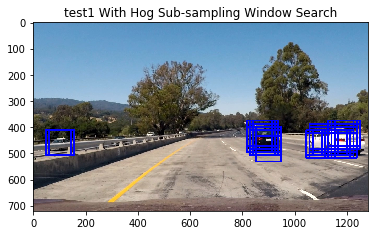

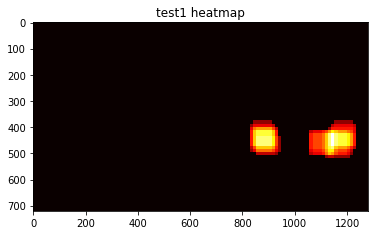

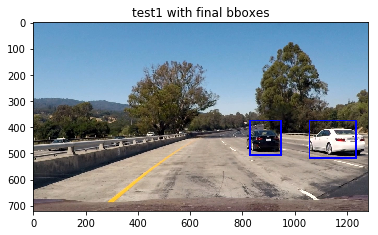

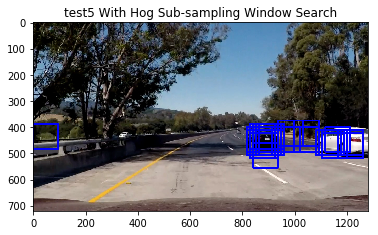

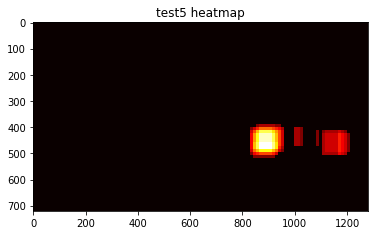

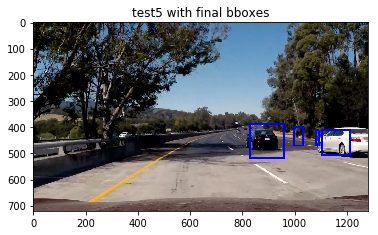

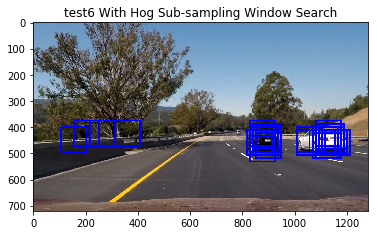

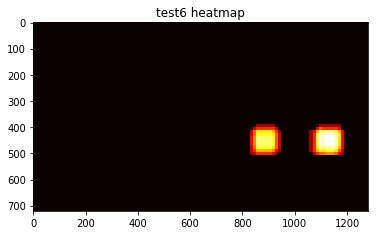

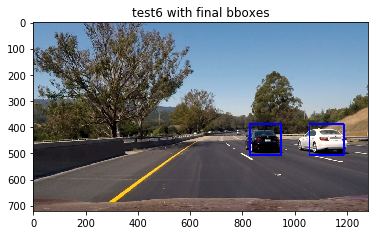

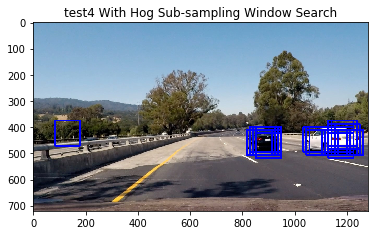

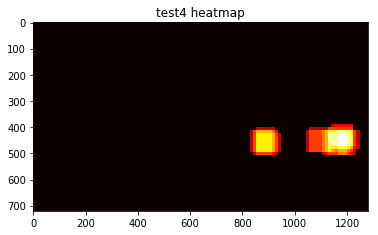

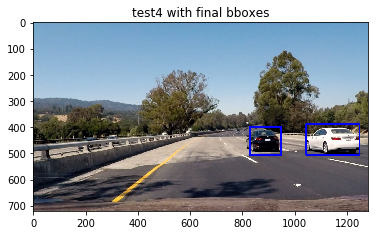

In [132]:
test_folder = "test_images/"
image_list = [image_name for image_name in os.listdir(test_folder) if image_name.endswith(".jpg")]
for image_name in image_list:
    img = mpimg.imread(test_folder+image_name)
    pipeline(img, True, image_name[:-4])

# Videos processing

In [56]:
from moviepy.editor import VideoFileClip

In [165]:
def process_video(file_name):
    def process_img(img):
        return pipeline(img, use_previous=True)    
    tracker.reset()
    video_input = VideoFileClip(file_name)#.subclip(10,15)
    processed_video = video_input.fl_image(process_img)
    %time processed_video.write_videofile(file_name[:-4]+'_outpt.mp4', audio=False)

In [168]:
process_video("test_video.mp4")

[MoviePy] >>>> Building video test_video_outpt.mp4
[MoviePy] Writing video test_video_outpt.mp4


 97%|█████████▋| 38/39 [00:24<00:00,  1.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_outpt.mp4 

CPU times: user 26.1 s, sys: 296 ms, total: 26.4 s
Wall time: 25.4 s


In [166]:
process_video("project_video.mp4")

[MoviePy] >>>> Building video project_video_outpt.mp4
[MoviePy] Writing video project_video_outpt.mp4


100%|█████████▉| 1260/1261 [11:19<00:00,  1.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_outpt.mp4 

CPU times: user 12min 41s, sys: 11.5 s, total: 12min 53s
Wall time: 11min 20s


In [66]:
video_input = VideoFileClip('project_video.mp4').subclip(14,15).write_images_sequence("project_images/frame%03d.jpg")

[MoviePy] Writing frames project_images/frame%03d.jpg.

25it [00:00, 37.44it/s]              

[MoviePy]: Done writing frames project_images/frame%03d.jpg.



In [ ]:
tracker.reset()
test_folder = "project_images/"
image_list = [image_name for image_name in os.listdir(test_folder) if image_name.endswith(".jpg")]
for image_name in image_list:
    img = mpimg.imread(test_folder+image_name)
    pipeline(img, True, image_name[:-4], True)

In [109]:
l=[1,2,3,4,5,6]

In [111]:
l[-n:]

[4, 5, 6]